# Fourier–Mellin Transform Approximations (TFMA) and Invariant Descriptors


**Dataset:** COIL-20 (Columbia Object Image Library).  
**Reference:** [*Robust and Efficient Fourier–Mellin Transform Approximations for Gray-Level Image Reconstruction and Complete Invariant Description*](https://www.researchgate.net/publication/222575345_Robust_and_Efficient_Fourier-Mellin_Transform_Approximations_for_Gray-Level_Image_Reconstruction_and_Complete_Invariant_Description)

**Goals**
- Implement analytic FMT approximations in polar and log-polar coordinates.
- Reconstruct images from each approximation and compute reconstruction error.
- Implement the invariant descriptors derived from TFMA (equation 9 in the paper) and study robustness on the COIL-20 dataset.

In [23]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.transform import warp_polar, rotate, warp, AffineTransform, rescale
from scipy.fft import fft, ifft

### Load and Preprocess the Grayscale Image

In [9]:
def load_gray_image(path):
    im = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    return im

def center_image_at_centroid(img):
    # Compute moments to find centroid
    moments = cv2.moments(img)
    if moments['m00'] != 0:
        cx = int(moments['m10'] / moments['m00'])
        cy = int(moments['m01'] / moments['m00'])
    else:
        cx, cy = img.shape[1] // 2, img.shape[0] // 2  # Fallback to center
    
    # Shift image to center centroid at image center
    rows, cols = img.shape
    shift_x = cols // 2 - cx
    shift_y = rows // 2 - cy
    M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    centered_img = cv2.warpAffine(img, M, (cols, rows))
    return centered_img

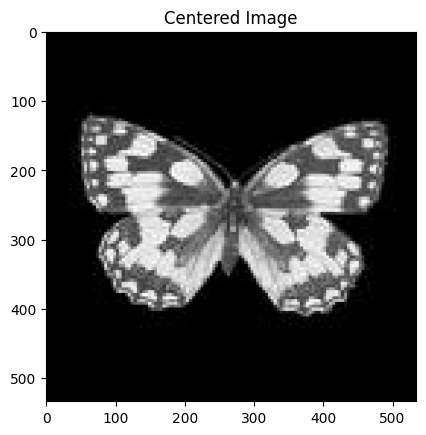

In [10]:
img = load_gray_image("./assets/butterfly.png")
centered_img = center_image_at_centroid(img)
plt.imshow(centered_img, cmap='gray')
plt.title('Centered Image')
plt.show()

### Transform Image to Polar Coordinates (for Direct-AFMT)

In [14]:
height, width = centered_img.shape
print(f"Height: {height}, Width: {width}")
R = width / 2

Height: 534, Width: 535


In [34]:
N = 256  # Radial beams
M = 128  # Angular circles
polar_img = cv2.warpPolar(centered_img, (M, N), (width/2, height/2), R, flags=cv2.WARP_POLAR_LINEAR + cv2.INTER_LINEAR)

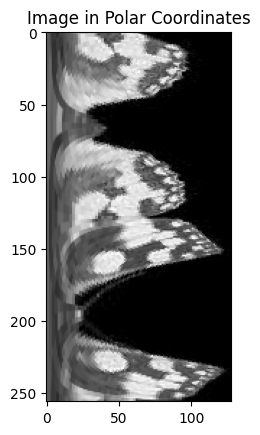

In [35]:
# polar_img is now (N, M) with rows as radial, columns as angular
plt.imshow(polar_img, cmap='gray')
plt.title('Image in Polar Coordinates')
plt.show()

In [36]:
sigma = 0.5
K = 20
V = 20

def compute_d_afmt(polar_img, N, M, R, sigma, K, V):
    delta_rho = R / N
    delta_theta = 2 * np.pi / M
    rho = np.arange(N) * delta_rho  # rho_n
    afmt = np.zeros((2*K+1, 2*V+1), dtype=complex)
    
    # Precompute angular FFT for each rho
    F_k = np.zeros((N, 2*K+1), dtype=complex)
    for n in range(N):
        angular_slice = polar_img[n, :]
        fft_angular = fft(angular_slice)
        F_k[n, :] = fft_angular[:2*K+1]  # Truncate to -K to K (assuming M > 2K+1)
    
    # Compute AFMT
    k_range = np.arange(-K, K+1)
    v_range = np.arange(-V, V+1)
    for idx_k, k in enumerate(k_range):
        for idx_v, v in enumerate(v_range):
            afmt[idx_k, idx_v] = delta_rho * delta_theta * np.sum(F_k[:, idx_k] * (rho ** (sigma - 1j*v - 1)))
    
    return afmt, k_range, v_range

In [37]:
afmt_polar, k_range, v_range = compute_d_afmt(polar_img, N, M, R, sigma, K, V)

C:\Users\ahmed\AppData\Local\Temp\ipykernel_7180\258730878.py:23: RuntimeWarning: invalid value encountered in power
  afmt[idx_k, idx_v] = delta_rho * delta_theta * np.sum(F_k[:, idx_k] * (rho ** (sigma - 1j*v - 1)))


In [38]:
idx_k0 = np.where(k_range == 0)[0][0]
idx_v0 = np.where(v_range == 0)[0][0]
idx_k1 = np.where(k_range == 1)[0][0]

M00 = afmt_polar[idx_k0, idx_v0]
M10 = afmt_polar[idx_k1, idx_v0]
arg_M10 = np.angle(M10)

descriptors_polar = np.zeros_like(afmt_polar, dtype=complex)
for idx_k, k in enumerate(k_range):
    for idx_v, v in enumerate(v_range):
        if afmt_polar[idx_k, idx_v] != 0:  # Avoid division by zero
            descriptors_polar[idx_k, idx_v] = (M00 ** (-sigma + 1j * v) * np.exp(1j * k * arg_M10)) / afmt_polar[idx_k, idx_v]
        else:
            descriptors_polar[idx_k, idx_v] = 0

# Descriptors are now in descriptors_polar (2K+1, 2V+1)
# For usage, you can flatten or use magnitudes for features, e.g., np.abs(descriptors_polar).flatten()

C:\Users\ahmed\AppData\Local\Temp\ipykernel_7180\4254303321.py:13: RuntimeWarning: invalid value encountered in scalar divide
  descriptors_polar[idx_k, idx_v] = (M00 ** (-sigma + 1j * v) * np.exp(1j * k * arg_M10)) / afmt_polar[idx_k, idx_v]


In [39]:
def reconstruct_from_d_afmt(afmt, N, M, R, sigma, K, V, k_range, v_range):
    delta_rho = R / N
    delta_theta = 2 * np.pi / M
    rho = np.arange(N) * delta_rho
    recon_polar = np.zeros((N, M), dtype=float)
    
    for n in range(N):
        G_v = np.zeros(M, dtype=complex)
        for m in range(M):
            theta_m = m * delta_theta
            sum_k = np.sum(afmt[:, :] * np.exp(1j * k_range[:, np.newaxis] * theta_m), axis=0)
            G_v[m] = np.sum(sum_k * (rho[n] ** (1j * v_range)))  # Wait, no: per theta
            
    # Correct inverse: First sum over v for each k, but better vectorize.
    
    # Better: Use ifft for angular
    recon_polar = np.zeros((N, M))
    for n in range(N):
        for m in range(M):
            theta = m * delta_theta
            sum_v = np.sum([afmt[idx_k, idx_v] * rho[n]**(1j * v_range[idx_v]) * np.exp(1j * k_range[idx_k] * theta) for idx_k in range(2*K+1) for idx_v in range(2*V+1)])
            recon_polar[n, m] = np.real(rho[n] ** (-sigma) * sum_v)
    
    # This is slow; optimize with FFT.
    # First, for each v, compute sum over k using ifft
    recon_polar = np.zeros((N, M))
    padded_afmt = np.zeros((2*V+1, M), dtype=complex)  # Pad for ifft
    for idx_v in range(2*V+1):
        afmt_v = np.zeros(M, dtype=complex)
        afmt_v[ M//2 - K : M//2 + K +1 ] = afmt[:, idx_v]  # Pad k to full M
        G_theta_v = ifft(afmt_v) * M  # Inverse FFT for theta (scale by M)
        for n in range(N):
            recon_polar[n, :] += np.real( rho[n] ** (-sigma + 1j * v_range[idx_v]) * G_theta_v )
    
    return recon_polar

recon_polar = reconstruct_from_d_afmt(afmt_polar, N, M, R, sigma, K, V, k_range, v_range)

# Warp back to Cartesian
recon_img_polar = cv2.warpPolar(recon_polar, (width, height), (width/2, height/2), R, flags=cv2.WARP_INVERSE_MAP + cv2.WARP_POLAR_LINEAR + cv2.INTER_LINEAR)

plt.imshow(recon_img_polar, cmap='gray')
plt.title('Reconstructed Image from Polar AFMT')
plt.show()

C:\Users\ahmed\AppData\Local\Temp\ipykernel_7180\3724583429.py:12: RuntimeWarning: invalid value encountered in power
  G_v[m] = np.sum(sum_k * (rho[n] ** (1j * v_range)))  # Wait, no: per theta
C:\Users\ahmed\AppData\Local\Temp\ipykernel_7180\3724583429.py:21: RuntimeWarning: invalid value encountered in scalar power
  sum_v = np.sum([afmt[idx_k, idx_v] * rho[n]**(1j * v_range[idx_v]) * np.exp(1j * k_range[idx_k] * theta) for idx_k in range(2*K+1) for idx_v in range(2*V+1)])
C:\Users\ahmed\AppData\Local\Temp\ipykernel_7180\3724583429.py:22: RuntimeWarning: divide by zero encountered in scalar power
  recon_polar[n, m] = np.real(rho[n] ** (-sigma) * sum_v)


KeyboardInterrupt: 